In [1]:
import io
import numpy as np
import PIL
import torch
import openpifpaf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from timeit import timeit
from time import time
import os
import cv2

/home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Checks versions

In [2]:
print('OpenPifPaf version', openpifpaf.__version__)
print('PyTorch version', torch.__version__)

OpenPifPaf version 0.13.11
PyTorch version 1.13.1


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 3050 Laptop GPU


# Images

### Gets an image and converts it to PIL image then numpy array

In [4]:
IMG_PATH = "Images/"
pil_im = PIL.Image.open((IMG_PATH+"shrek.JPG")).convert('RGB')
im = np.asarray(pil_im)

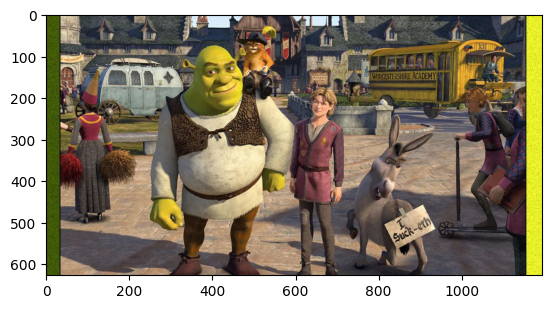

In [5]:
plt.imshow(im)

### Predicts

In [6]:
# possible pre trained models
[c for c, u in openpifpaf.CHECKPOINT_URLS.items() if isinstance(u, str)]

['shufflenetv2k30-animalpose',
 'shufflenetv2k16-apollo-24',
 'shufflenetv2k16-apollo-66',
 'shufflenetv2k30-apollo-66',
 'mobilenetv2',
 'mobilenetv3small',
 'mobilenetv3large',
 'resnet50',
 'shufflenetv2k16',
 'shufflenetv2k16-withdense',
 'shufflenetv2k30',
 'mobilenetv3small-cocodet',
 'resnet18-cocodet',
 'resnet50-crowdpose',
 'shufflenetv2k16-nuscenes',
 'tshufflenetv2k30',
 'shufflenetv2k16-wholebody',
 'shufflenetv2k30-wholebody']

In [7]:
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16') #could use mobilenetv3small for betterperformances
predictions, gt_anns, image_meta = predictor.pil_image(pil_im)

src/openpifpaf/csrc/src/cif_hr.cpp:102: UserInfo: resizing cifhr buffer
src/openpifpaf/csrc/src/occupancy.cpp:53: UserInfo: resizing occupancy buffer


In [8]:
start = time()
predictions, _, _ = predictor.pil_image(pil_im)
stop = time()
duration = stop-start
print(f"duration = {duration:.2f}s")

duration = 0.15s


### We use MS coco skeleton

In [9]:
for i, name in enumerate(openpifpaf.plugins.coco.constants.COCO_KEYPOINTS):
    print(i, name)

0 nose
1 left_eye
2 right_eye
3 left_ear
4 right_ear
5 left_shoulder
6 right_shoulder
7 left_elbow
8 right_elbow
9 left_wrist
10 right_wrist
11 left_hip
12 right_hip
13 left_knee
14 right_knee
15 left_ankle
16 right_ankle


![Coordinates](openpifpaf_coordinates.png)

In [10]:
predictions[0].data # for person of index 0, each keypoint x, y ,confidence

array([[655.5931    , 222.15228   ,   0.9746474 ],
       [667.7661    , 215.12592   ,   0.99894506],
       [650.38257   , 210.98392   ,   0.97503525],
       [685.0627    , 222.49873   ,   0.98906904],
       [639.83417   , 213.79205   ,   0.91740876],
       [697.30023   , 282.3052    ,   0.9853889 ],
       [611.48175   , 270.1398    ,   0.976607  ],
       [705.0056    , 350.91382   ,   0.97389317],
       [599.72455   , 337.7863    ,   0.96926343],
       [703.59656   , 414.11462   ,   0.9751259 ],
       [594.5018    , 393.66525   ,   0.9402814 ],
       [663.85565   , 397.44363   ,   0.977862  ],
       [616.9104    , 391.18402   ,   0.9739861 ],
       [673.4544    , 501.95343   ,   0.978421  ],
       [625.0128    , 498.87268   ,   0.9501031 ],
       [683.3032    , 602.4662    ,   0.96723205],
       [626.5491    , 601.7794    ,   0.9443159 ]], dtype=float32)

In [11]:
openpifpaf.show.Canvas.show = True
openpifpaf.show.Canvas.image_min_dpi = 100

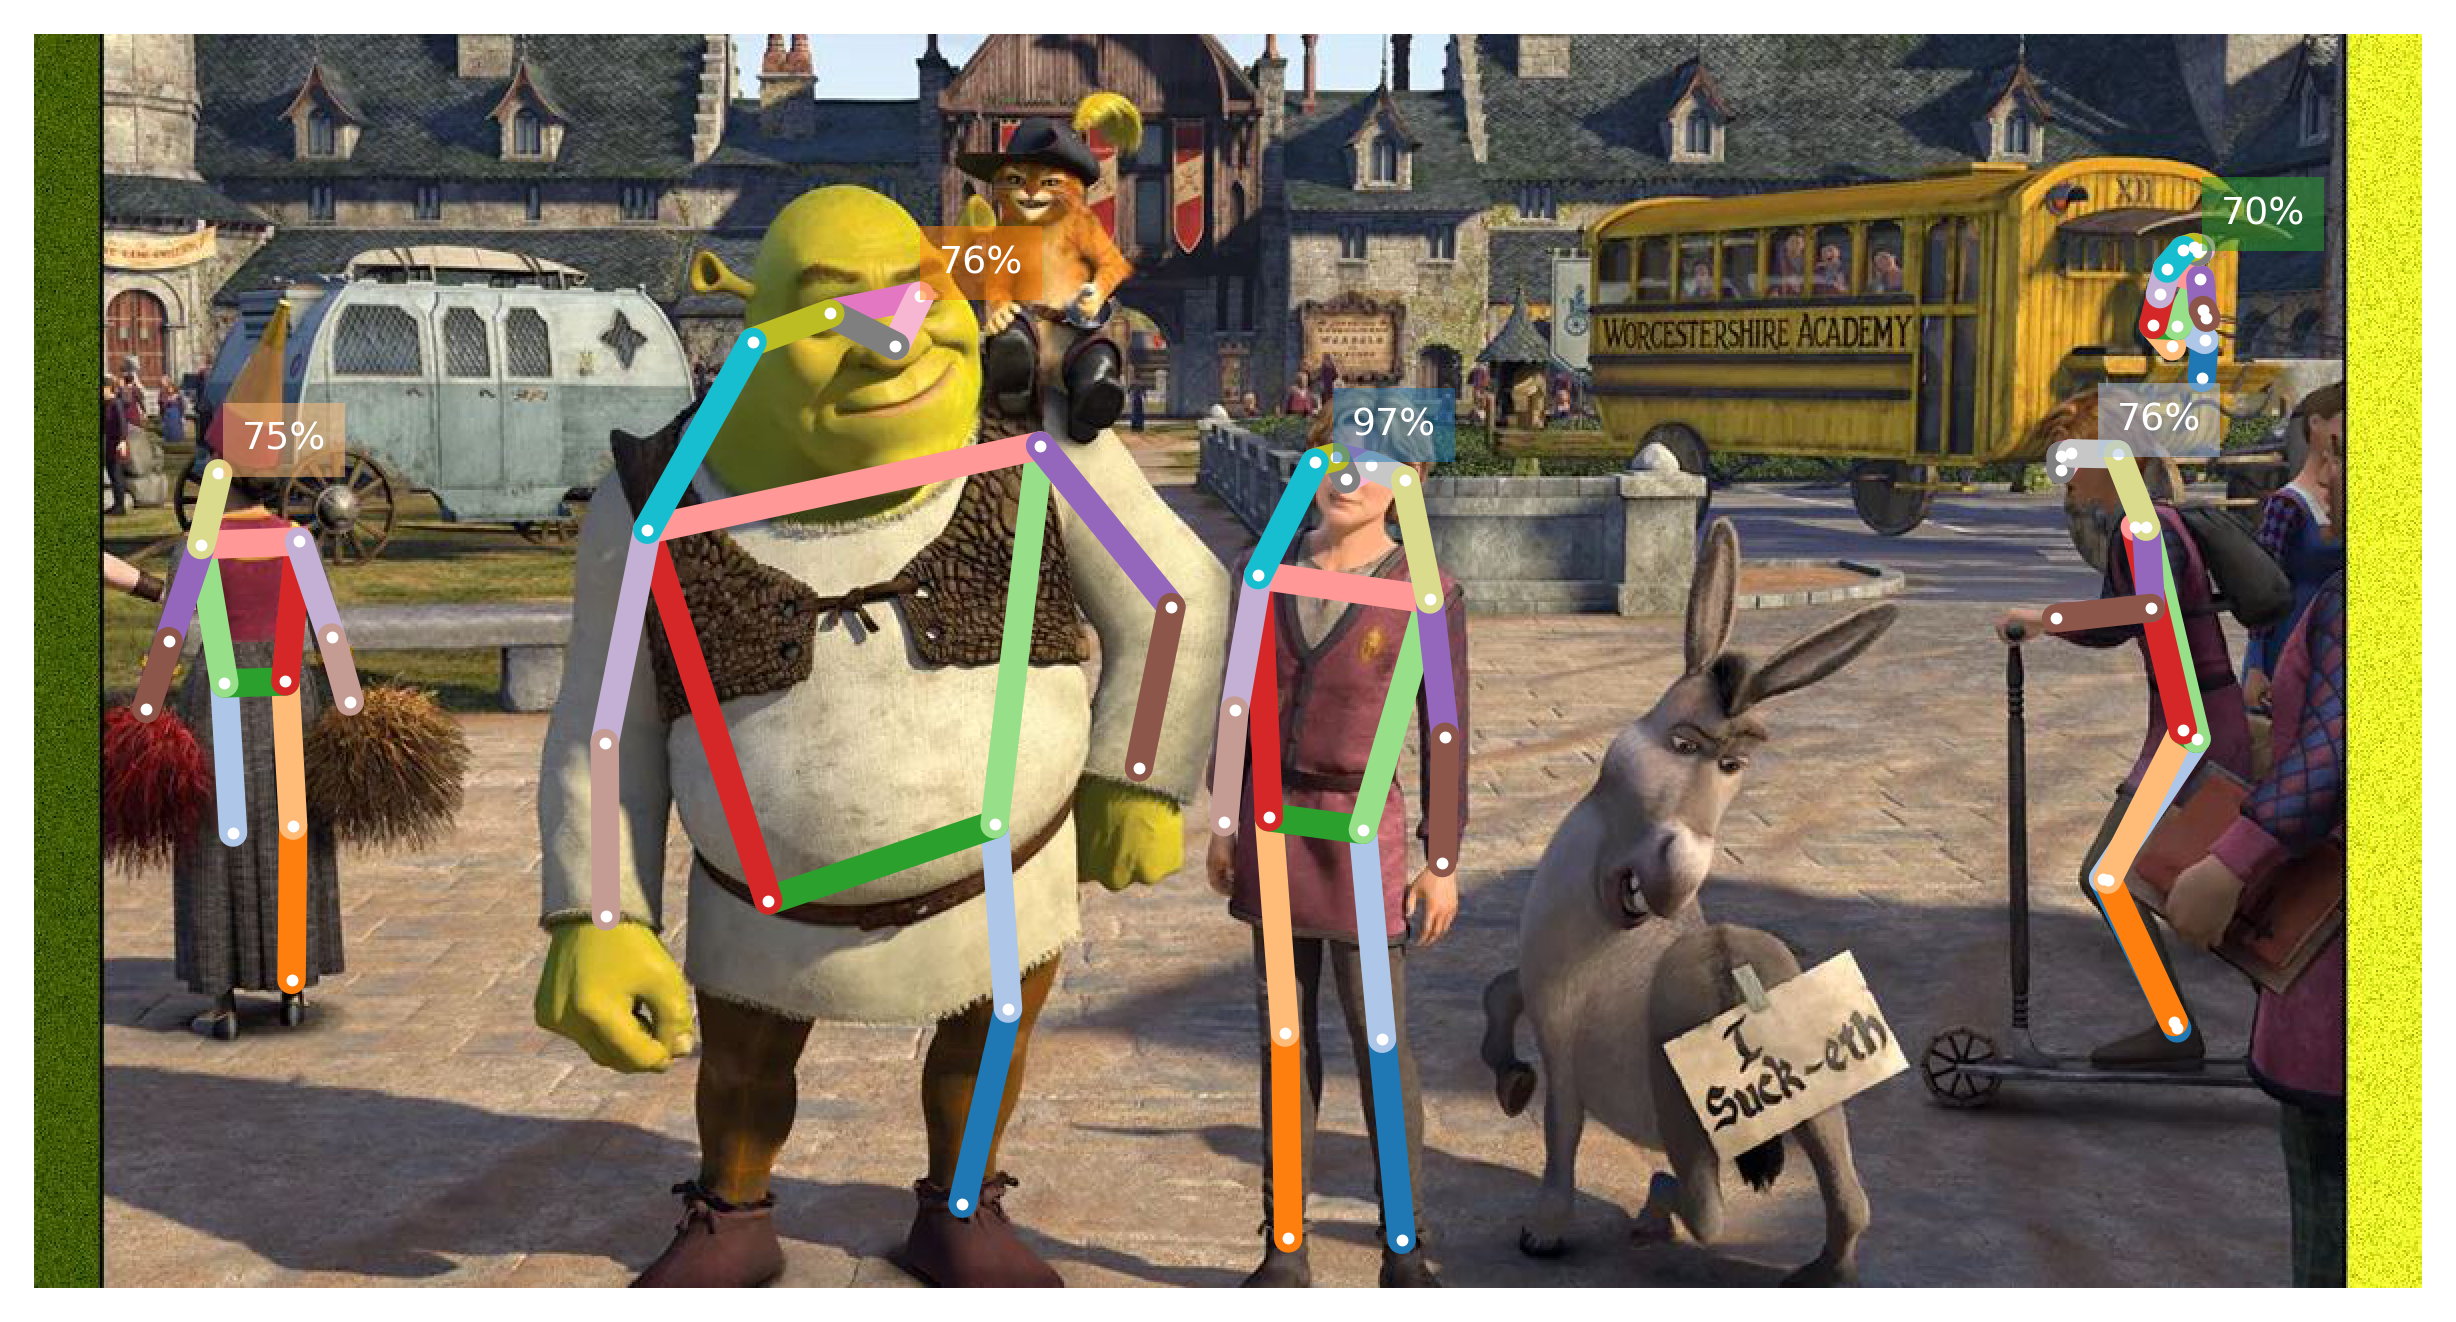

In [12]:
annotation_painter = openpifpaf.show.AnnotationPainter()
with openpifpaf.show.image_canvas(im) as ax:
    annotation_painter.annotations(ax, predictions, )

In [13]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def compute_angle(shoudler, hip, elbow):
    """ Returns the angle in radiants between of the arm defined by its shoudler, hip and elbow"""
    v1 = unit_vector(hip - shoudler)
    v2 = unit_vector(elbow - shoudler)
    return np.arccos(np.clip(np.dot(v1, v2),-1.0,1.0))*360/(2*np.pi)

  
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def compute_angle(shoudler, hip, elbow):
    """ Returns the angle in radiants between of the arm defined by its shoudler, hip and elbow"""
    v1 = unit_vector(hip - shoudler)
    v2 = unit_vector(elbow - shoudler)
    return np.arccos(np.clip(np.dot(v1, v2),-1.0,1.0))*360/(2*np.pi)

def compute_arms_angle(prediction):
    """ Returns the angle of left and right arm wrt to the torso (return nan if the arm is not seen) """
    
    pos_dict = {
        "nose": 0,
        "left_eye": 1,
        "right_eye": 2,
        "left_ear": 3,
        "right_ear": 4,
        "left_shoudler": 5,
        "right_shoudler": 6,
        "left_elbow": 7,
        "right_elbow": 8,
        "left_wrist": 9,
        "right_wrist": 10,
        "left_hip": 11,
        "right_hip": 12,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16}
    
    # we suppose only on person on the image (index = 0)
    keypoints = predictions[0].data

    # left arm
    left_shoulder = keypoints[pos_dict["left_shoudler"],0:2]
    left_hip = keypoints[pos_dict["left_hip"],0:2]
    left_elbow = keypoints[pos_dict["left_elbow"],0:2]

    # right arm
    right_shoulder = keypoints[pos_dict["right_shoudler"],0:2]
    right_hip = keypoints[pos_dict["right_hip"],0:2]
    right_elbow = keypoints[pos_dict["right_elbow"],0:2]

    return(compute_angle(left_shoulder, left_hip, left_elbow), compute_angle(right_shoulder, right_hip, right_elbow))

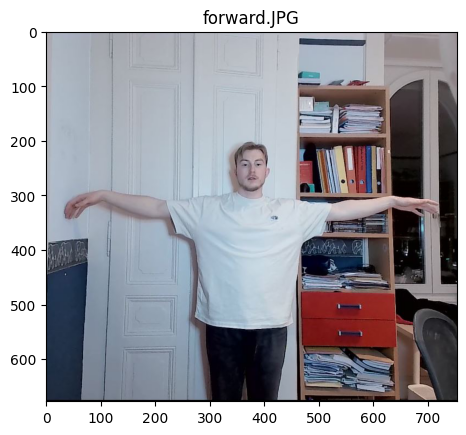

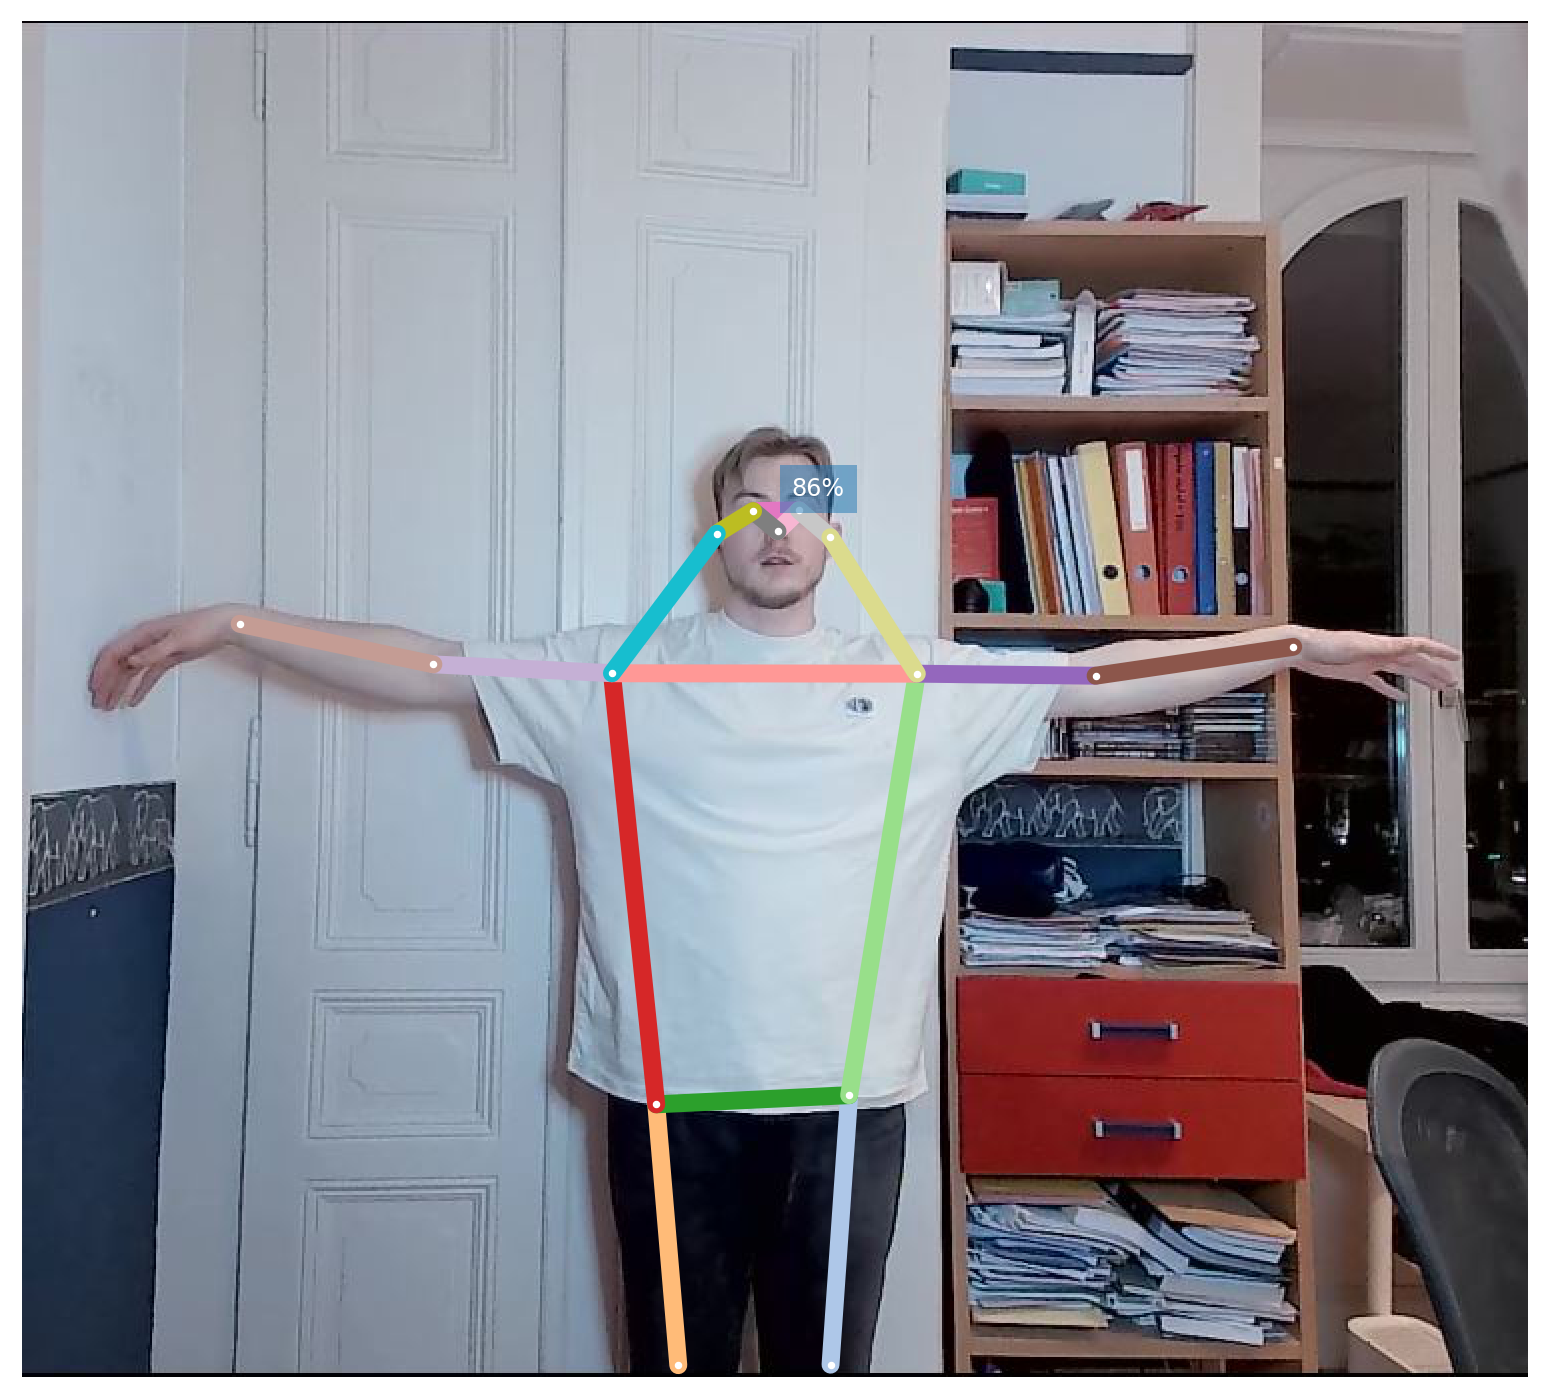

Angle of the left arm : 98.4658004785809
Angle of the right arm : 98.722917722336


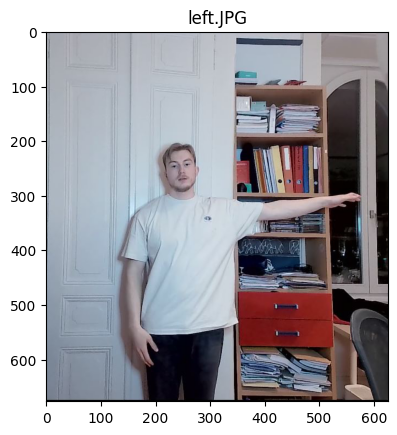

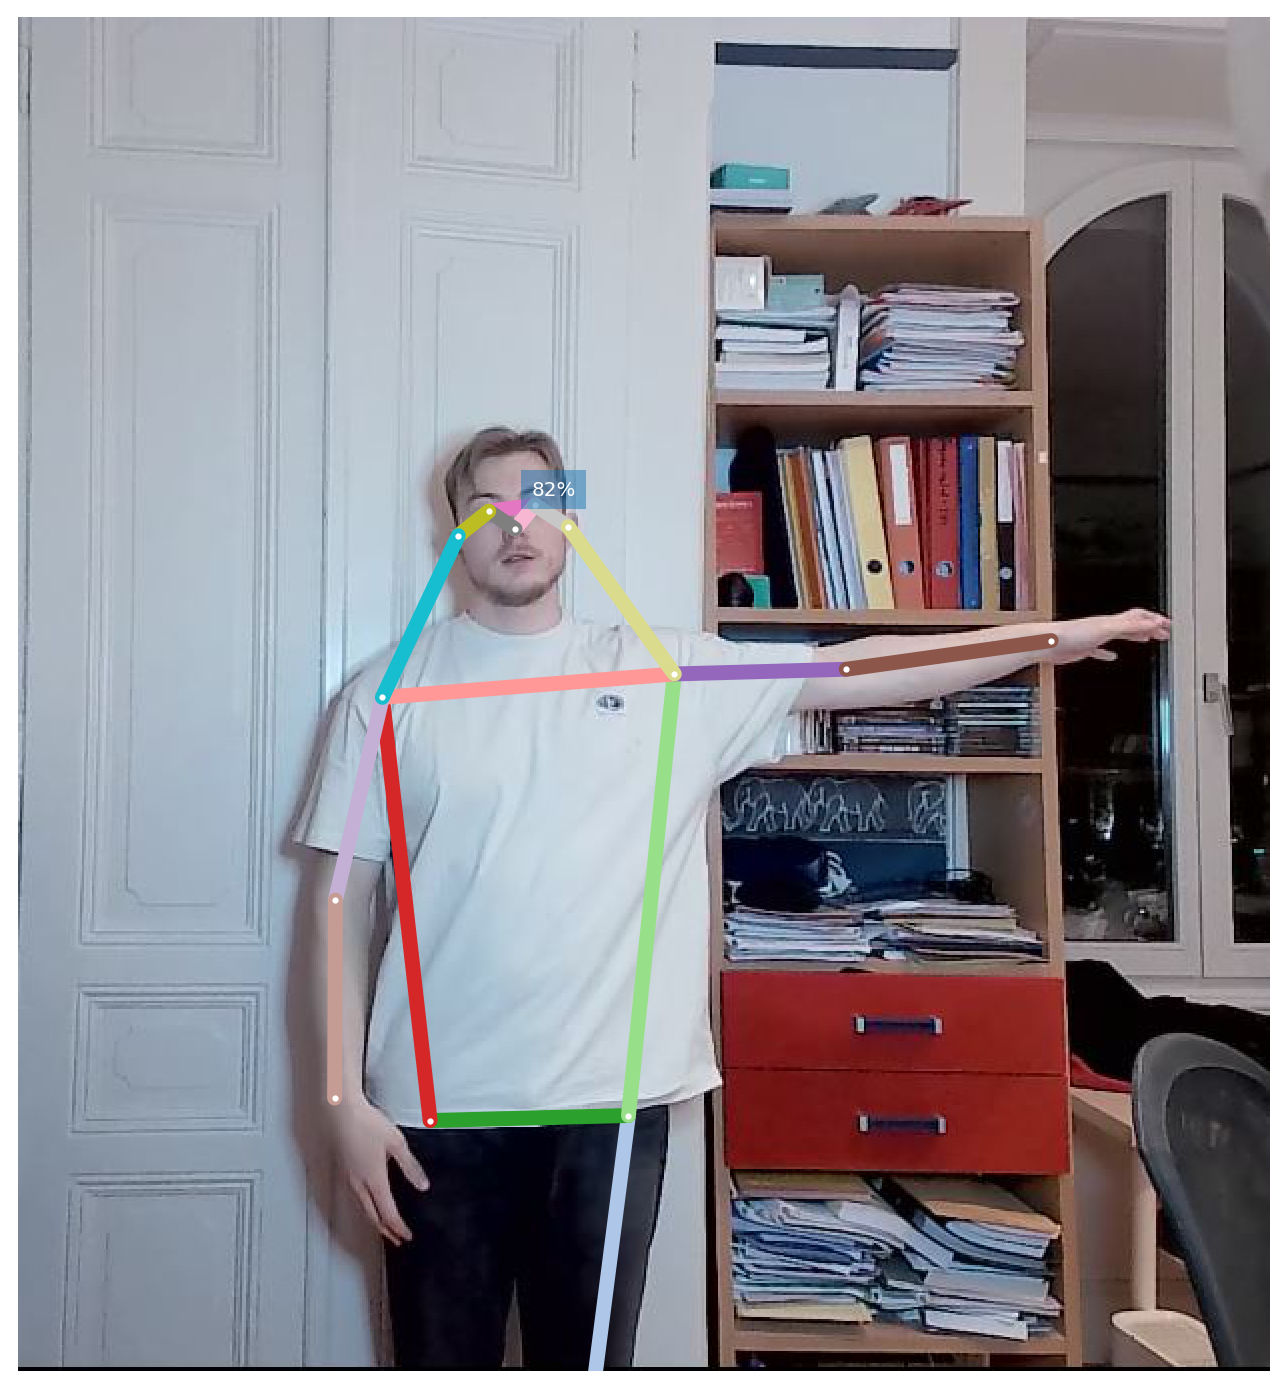

Angle of the left arm : 97.50134555000561
Angle of the right arm : 19.483244387707796


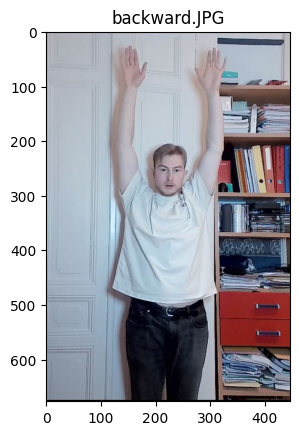

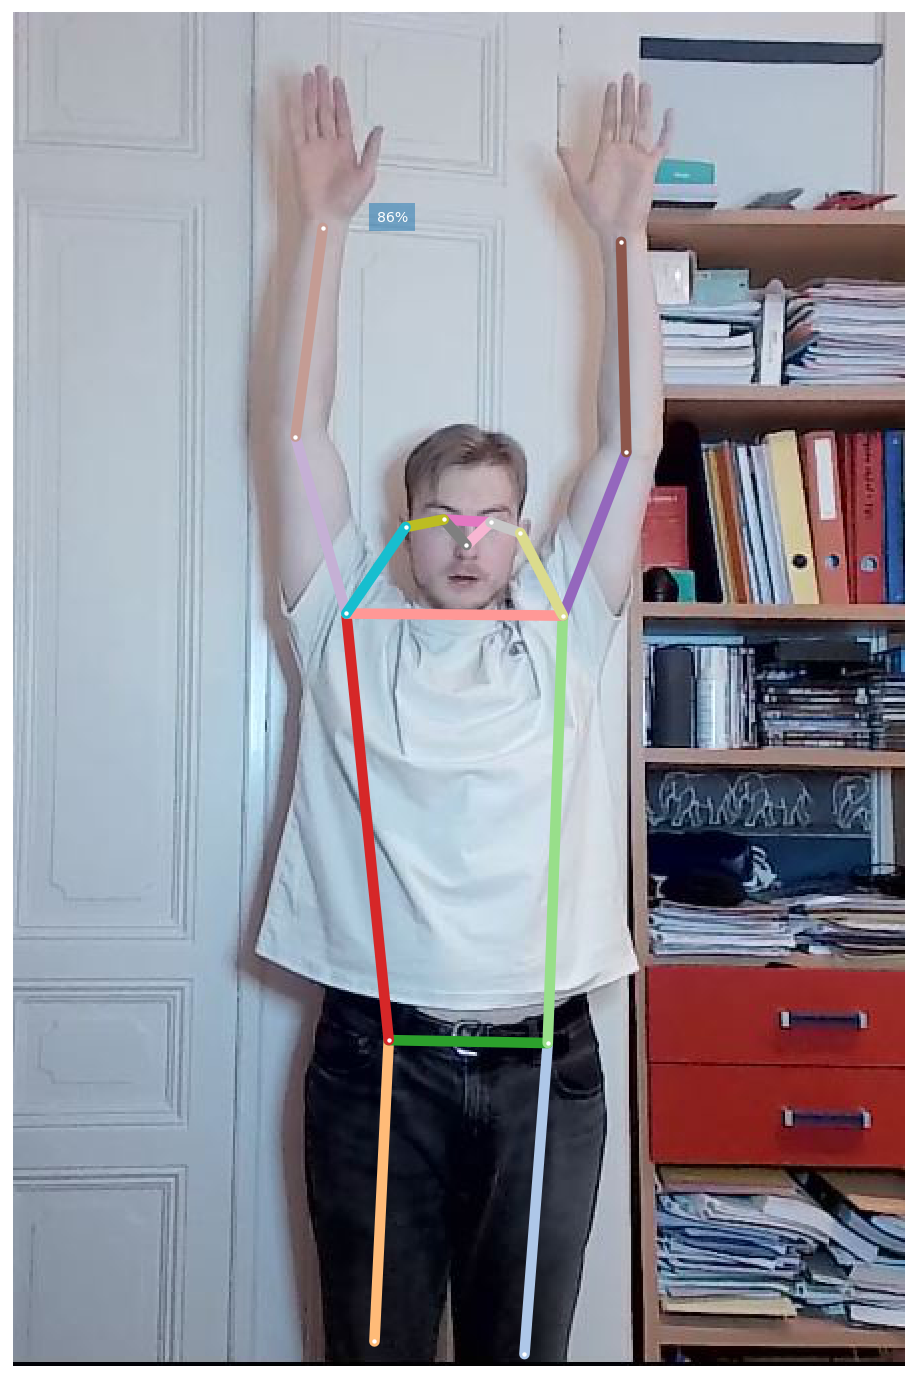

Angle of the left arm : 160.78894001936516
Angle of the right arm : 169.64837121991874


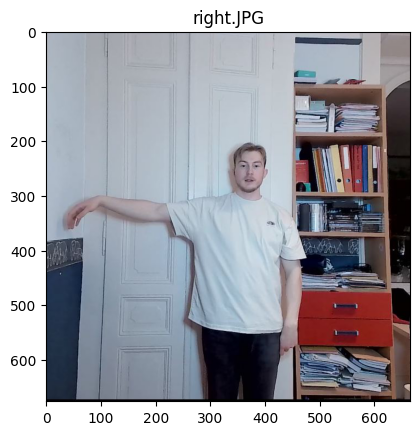

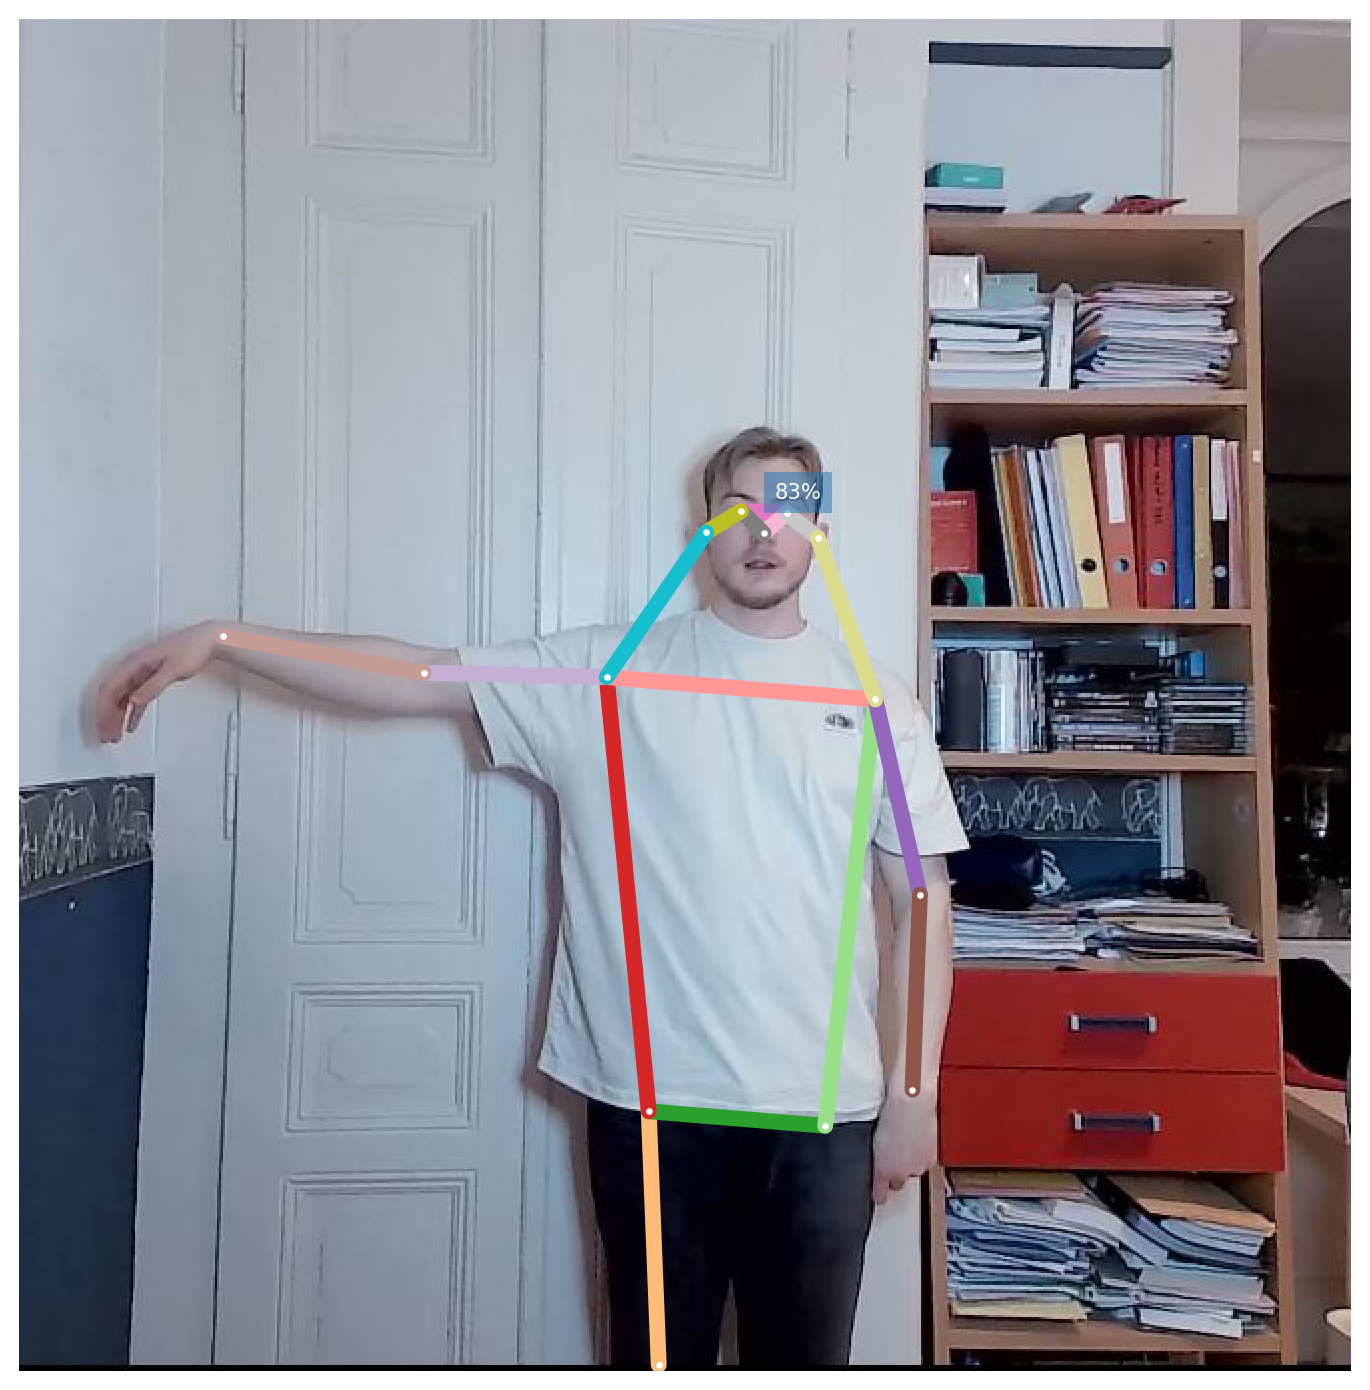

Angle of the left arm : 19.569744980934914
Angle of the right arm : 96.89822041876288


In [14]:
POSES_PATH = IMG_PATH+"poses/"

annotation_painter = openpifpaf.show.AnnotationPainter()

for file in os.listdir(POSES_PATH):
    pil_img = PIL.Image.open((POSES_PATH+file)).convert('RGBA')
    img = np.asarray(pil_img)

    # base image 
    plt.imshow(img)
    plt.title(file)

    # image with keypoints
    predictions, _, _ = predictor.pil_image(pil_img)
    with openpifpaf.show.image_canvas(img) as ax:
        annotation_painter.annotations(ax, predictions)

    # angles of the arms
    left_angle, right_angle = compute_arms_angle(predictions)
    print(f"Angle of the left arm : {left_angle}\nAngle of the right arm : {right_angle}")
plt.show()

# Video

`python -m openpifpaf.video --source=0 --show --horizontal-flip` for a video demo
`python3 -m openpifpafwebdemo.server` for another video demo

In [15]:
def angles_to_command(left_angle, right_angle):
    """Returns the command corresponding to arms angle"""
    
    up_angle = 160
    horizontal_angle = 90
    down_angle = 20
    margin = 15

    # backward angle = 160 +/- 10
    if (left_angle > up_angle-margin and left_angle < up_angle+margin) and (right_angle > up_angle-margin and right_angle < up_angle+margin):
        return "backward"
    # forward angle = 90 +/- 10
    if (left_angle > horizontal_angle-margin and left_angle < horizontal_angle+margin) and (right_angle > horizontal_angle-margin and right_angle < horizontal_angle+margin):
        return "forward"
    # left = left: 90 +/- 10 right: 20 +/- 10
    if (left_angle > horizontal_angle-margin and left_angle < horizontal_angle+margin) and (right_angle > down_angle-margin and right_angle < down_angle+margin):
        return "left"
    # right = left: 20 +/- 10 right: 90 +/- 10
    if (left_angle > down_angle-margin and left_angle < down_angle+margin) and (right_angle > horizontal_angle-margin and right_angle < horizontal_angle+margin):
        return "right"
    else:
        return "stop"
    

In [16]:
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)

pos_dict = {
        "nose": 0,
        "left_eye": 1,
        "right_eye": 2,
        "left_ear": 3,
        "right_ear": 4,
        "left_shoudler": 5,
        "right_shoudler": 6,
        "left_elbow": 7,
        "right_elbow": 8,
        "left_wrist": 9,
        "right_wrist": 10,
        "left_hip": 11,
        "right_hip": 12,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16}


In [17]:
cap = cv2.VideoCapture(0)
debug = False 

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")


while True:
    start = time()
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA) #tweak those values to get better performance

    c = cv2.waitKey(1)
    if c == 27: # press escape to quit
        break
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = PIL.Image.fromarray(img)

    predictions, _, _ = predictor.pil_image(pil_img)

    if debug:
        print(f"Angle of the left arm : {left_angle}\nAngle of the right arm : {right_angle}\n")

    try:
        left_angle, right_angle = compute_arms_angle(predictions)

        # writes desired command
        command = angles_to_command(left_angle, right_angle)
        cv2.putText(img = frame, text=f"command: {command}", org = (0,60), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=GREEN,thickness=3)

        #draw arms and hips
        keypoints = predictions[0].data

        # left arm
        left_shoulder = keypoints[pos_dict["left_shoudler"],0:2]
        left_hip = keypoints[pos_dict["left_hip"],0:2]
        left_elbow = keypoints[pos_dict["left_elbow"],0:2]

        # right arm
        right_shoulder = keypoints[pos_dict["right_shoudler"],0:2]
        right_hip = keypoints[pos_dict["right_hip"],0:2]
        right_elbow = keypoints[pos_dict["right_elbow"],0:2]

        cv2.line(frame, tuple(map(int, tuple(left_shoulder))), tuple(map(int, tuple(left_elbow))), RED, 5)
        cv2.line(frame, tuple(map(int, tuple(left_shoulder))), tuple(map(int, tuple(left_hip))), YELLOW, 5)
        cv2.line(frame, tuple(map(int, tuple(right_shoulder))), tuple(map(int, tuple(right_elbow))), RED, 5)
        cv2.line(frame, tuple(map(int, tuple(right_shoulder))), tuple(map(int, tuple(right_hip))), YELLOW, 5)
    except:
        cv2.putText(img = frame, text=f"no detection", org = (0,60), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=GREEN,thickness=2)
    
    stop = time()

    # writes fps
    fps = 1/(stop-start)
    cv2.putText(img = frame, text=f"{fps:.2f} fps", org = (0,30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=GREEN,thickness=2)

    # Naming a window
    cv2.namedWindow('Resized_Window', cv2.WINDOW_NORMAL)
    
    cv2.imshow('Resized_Window', frame)

cap.release()
cv2.destroyAllWindows()

/tmp/ipykernel_11986/3866864029.py:14: RuntimeWarning: invalid value encountered in divide
  return vector / np.linalg.norm(vector)


# Using Intel Realsense camera

In [1]:
import pyrealsense2 as rs

In [2]:
pipeline = rs.pipeline()
config = rs.config()

In [3]:
# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

In [4]:
found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)


In [8]:
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 1280, 800, rs.format.bgr8, 30)


In [9]:
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16') #could use mobilenetv3small for betterperformances

In [16]:
# Start streaming
#pipeline.stop()
pipeline.start(config)

debug = False

while True:

    c = cv2.waitKey(1)
    if c == 27: # press escape to quit
        break

    # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    if not depth_frame or not color_frame:
        continue

    # Convert images to numpy arrays
    depth_image = np.asanyarray(depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())
    
    # ==== OPENPIFPAF =====
    # img = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
    pil_img = PIL.Image.fromarray(color_image)
    frame = color_image

    predictions, _, _ = predictor.pil_image(pil_img)

    if debug:
        print(f"Angle of the left arm : {left_angle}\nAngle of the right arm : {right_angle}\n")

    try:
        left_angle, right_angle = compute_arms_angle(predictions)

        # writes desired command
        command = angles_to_command(left_angle, right_angle)
        cv2.putText(img = frame, text=f"command: {command}", org = (0,60), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=GREEN,thickness=3)

        #draw arms and hips
        keypoints = predictions[0].data

        # left arm
        left_shoulder = keypoints[pos_dict["left_shoudler"],0:2]
        left_hip = keypoints[pos_dict["left_hip"],0:2]
        left_elbow = keypoints[pos_dict["left_elbow"],0:2]

        # right arm
        right_shoulder = keypoints[pos_dict["right_shoudler"],0:2]
        right_hip = keypoints[pos_dict["right_hip"],0:2]
        right_elbow = keypoints[pos_dict["right_elbow"],0:2]

        cv2.line(frame, tuple(map(int, tuple(left_shoulder))), tuple(map(int, tuple(left_elbow))), RED, 5)
        cv2.line(frame, tuple(map(int, tuple(left_shoulder))), tuple(map(int, tuple(left_hip))), YELLOW, 5)
        cv2.line(frame, tuple(map(int, tuple(right_shoulder))), tuple(map(int, tuple(right_elbow))), RED, 5)
        cv2.line(frame, tuple(map(int, tuple(right_shoulder))), tuple(map(int, tuple(right_hip))), YELLOW, 5)
    except:
        cv2.putText(img = frame, text=f"no detection", org = (0,60), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=GREEN,thickness=2)

    # ==== OPENPIFPAF =====
    
    # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

    depth_colormap_dim = depth_colormap.shape
    color_colormap_dim = color_image.shape

    # # If depth and color resolutions are different, resize color image to match depth image for display
    # if depth_colormap_dim != color_colormap_dim:
    #     resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
    #     images = np.hstack((resized_color_image, depth_colormap))
    # else:
    #     images = np.hstack((color_image, depth_colormap))

    # Show images
    cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
    cv2.imshow('RealSense', frame)
    cv2.waitKey(1)

# Stop streaming
pipeline.stop()

# Release resources
cv2.destroyAllWindows()

In [15]:
pipeline.stop()

In [12]:
pipeline.start(config)
frames = pipeline.wait_for_frames()
depth_frame = frames.get_depth_frame()
color_frame = frames.get_color_frame()
pipeline.stop()

In [14]:
color_image = np.asanyarray(color_frame.get_data())

In [19]:
pil_img = PIL.Image.fromarray(color_image)
predictions, _, _ = predictor.pil_image(pil_img)
print(predictions[0].data)


[[5.4591913e+02 2.8251132e+02 9.9136710e-01]
 [5.9157544e+02 2.4987309e+02 9.9742782e-01]
 [5.1924921e+02 2.5003258e+02 9.8666990e-01]
 [6.5628839e+02 2.9545312e+02 9.7797978e-01]
 [4.8506616e+02 2.8739188e+02 9.2000514e-01]
 [7.5598126e+02 4.9346265e+02 9.2554075e-01]
 [4.0349796e+02 4.8912186e+02 8.7655246e-01]
 [9.3506964e+02 6.5300037e+02 4.6917468e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [22]:
left_angle, right_angle = compute_arms_angle(predictions)

In [30]:
frame = color_image

In [31]:
# writes desired command
command = angles_to_command(left_angle, right_angle)
cv2.putText(img = frame, text=f"command: {command}", org = (0,60), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=GREEN,thickness=3)

#draw arms and hips
keypoints = predictions[0].data

# left arm
left_shoulder = keypoints[pos_dict["left_shoudler"],0:2]
left_hip = keypoints[pos_dict["left_hip"],0:2]
left_elbow = keypoints[pos_dict["left_elbow"],0:2]

# right arm
right_shoulder = keypoints[pos_dict["right_shoudler"],0:2]
right_hip = keypoints[pos_dict["right_hip"],0:2]
right_elbow = keypoints[pos_dict["right_elbow"],0:2]

cv2.line(frame, tuple(map(int, tuple(left_shoulder))), tuple(map(int, tuple(left_elbow))), RED, 5)
cv2.line(frame, tuple(map(int, tuple(left_shoulder))), tuple(map(int, tuple(left_hip))), YELLOW, 5)
cv2.line(frame, tuple(map(int, tuple(right_shoulder))), tuple(map(int, tuple(right_elbow))), RED, 5)
cv2.line(frame, tuple(map(int, tuple(right_shoulder))), tuple(map(int, tuple(right_hip))), YELLOW, 5)

array([[[  0, 255, 255],
        [  0, 255, 255],
        [  0, 255, 255],
        ...,
        [  0,  20,  47],
        [  0,  21,  48],
        [  0,  21,  48]],

       [[  0, 255, 255],
        [  0, 255, 255],
        [  0, 255, 255],
        ...,
        [  0,  21,  45],
        [  0,  22,  46],
        [  0,  22,  46]],

       [[  0, 255, 255],
        [  0, 255, 255],
        [  0, 255, 255],
        ...,
        [  0,  21,  45],
        [  0,  22,  46],
        [  0,  22,  46]],

       ...,

       [[  5,  31,  92],
        [  4,  30,  91],
        [  0,  30,  90],
        ...,
        [  0,  16,  28],
        [  0,  12,  27],
        [  0,  12,  27]],

       [[  6,  31,  89],
        [  6,  31,  89],
        [  2,  32,  89],
        ...,
        [  0,  14,  26],
        [  0,  14,  26],
        [  0,  14,  26]],

       [[  4,  30,  91],
        [  4,  30,  91],
        [  0,  31,  91],
        ...,
        [  0,  14,  26],
        [  0,  14,  26],
        [  0,  14,  26]]

In [34]:
cv2.imshow("hw",frame)
cv2.waitKey(0)

27

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\eliot\anaconda3\envs\semproj\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\eliot\anaconda3\envs\semproj\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\eliot\anaconda3\envs\semproj\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\eliot\anaconda3\envs\semproj\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 1

: 